# ECON240 (Regression), Fall 2021, Problem Set 3
Satej Soman, satej@berkeley.edu

## 0. preliminaries: install needed packages, import libraries, and set up plotting options

In [1]:
! pip3 install numpy scipy matplotlib seaborn pandas requests

In [2]:
import io
from itertools import dropwhile, takewhile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy
import seaborn as sns

Normal = scipy.stats.norm

np.set_printoptions(edgeitems = 30, linewidth = 5000, formatter = dict(float = lambda x: "%.5g" % x))
π = np.pi

sns.set_theme(context = "notebook", palette = "bright")
plt.rc("axes.spines", top = False, right = False)
plt.rc("font", **{'family':'sans-serif', 'sans-serif':'Helvetica Neue'})
plt.rc('figure', dpi = 200)

# we'll use string keys to index dicts of numpy arrays representing the stacked samples and estimates
test_functions = (s, b)           = ("steps", "bimodal")
estimators     = (ML, Ef, ST, OS) = ("maximum likelihood", "Efromovich", "soft threshold", "ordered subset")


# 1. K Normal Means, problem (5)

First, let's set up the cosine basis elements, $\phi_k(x)$, as well as the bimodal and steps functions discussed in Efromovich, and visualize them.

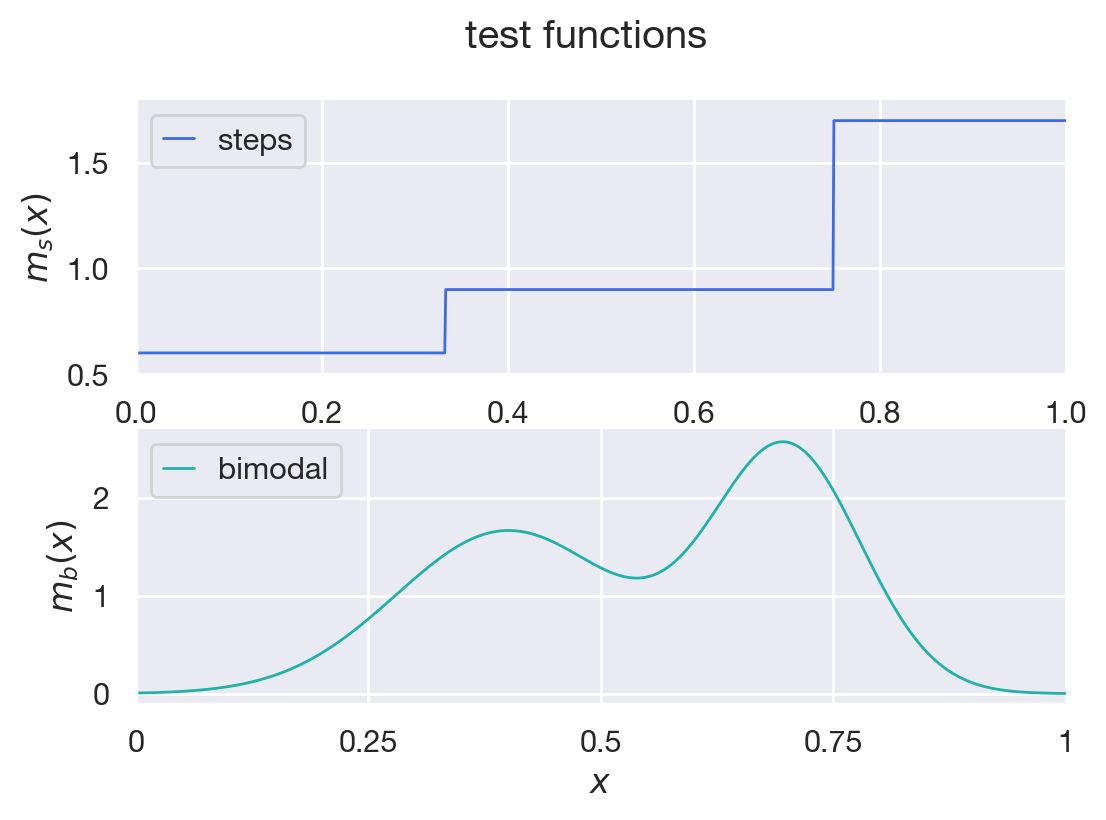

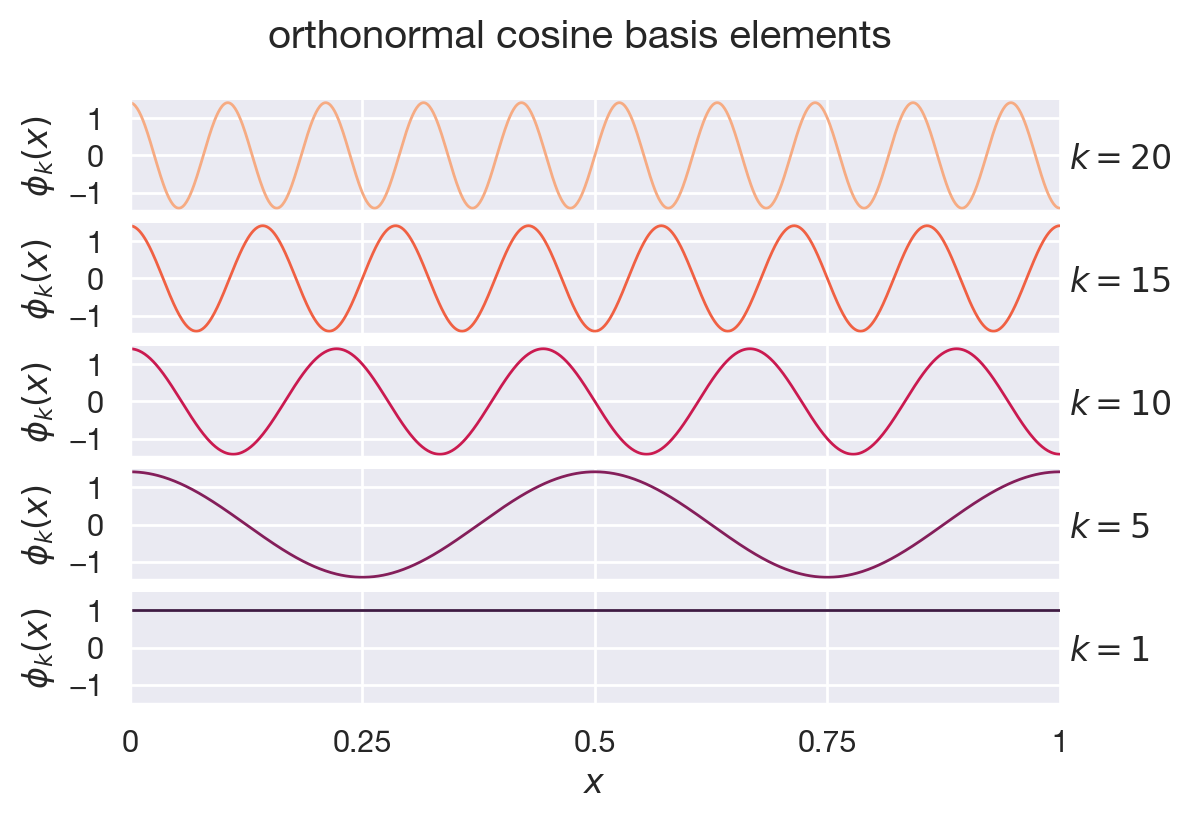

In [3]:
# define the functions we need across the estimator implementations
def ϕ(k, x):
    """ kth basis element of the cosine orthonormal system """
    return (np.sqrt(2) ** (k > 1)) * np.cos(π * (k-1) * x[:, None])

μ_1, σ_1 = 0.4, 0.12
μ_2, σ_2 = 0.7, 0.08
mode_1 = Normal(μ_1, σ_1)
mode_2 = Normal(μ_2, σ_2)
def mb(x: np.array) -> np.array:
    """ bimodal test function """ 
    return (mode_1.pdf(x) + mode_2.pdf(x))/2

def ms(x: np.array) -> np.array:
    """ steps test function """
    return (0.6 * ((0   <= x) & (x <  1/3)) +
            0.9 * ((1/3 <= x) & (x <  3/4)) +
            1.7 * ((3/4 <= x) & (x <= 1))   )

m = {s: ms, b: mb}

# set up consistent plot settings for visualization
ylims      = {s: ( 0.5, 1.8), b: (-0.1, 2.7)}
ylims_data = {s: (-1.0, 3.0), b: (-1.2, 4.0)}
colors     = {s: "royalblue", b: "lightseagreen"}

# visualize the test functions
fig, axs = plt.subplots(ncols = 1, nrows = 2)
for (ax, j) in zip(axs.flat, (s, b)):
    x = np.linspace(0, 1, 1000)
    ax.plot(x, m[j](x), color = colors[j], lw = 1, label = j)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$m_{" + j[0] + "}(x)$")
    ax.set_xlim(0, 1)
    ax.set_ylim(*ylims[j])
    ax.grid(True)
    ax.legend(loc = "upper left", handlelength = 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
plt.suptitle("test functions")
plt.show()

# visualize the basis functions
(fig, axs) = plt.subplots(ncols = 1, nrows = 5)
for (k, color, ax) in zip([20, 15, 10, 5, 1], sns.color_palette("rocket_r", n_colors = 5), axs.flat):
    plt.sca(ax)
    plt.plot(np.linspace(0, 1, 1000), ϕ(k, np.linspace(0, 1, 1000)), color = color, label = f"$k$ = {k}", lw = 1)
    plt.text(s = f"\n$k = {k}$", x = 1.01, y = 0.35, va = "center")
    plt.ylim(-1.5, 1.5)
    plt.xlim(0, 1)
    plt.ylabel("$\phi_k(x)$")
    plt.xticks([0, 0.25, 0.5, 0.75, 1], ["", "" ,"", "", ""])
plt.xlabel("$x$")
plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
plt.subplots_adjust(hspace = 0.1)
plt.suptitle("orthonormal cosine basis elements")
plt.show()

Next, set the random seed for reproducibility, set up the problem parameters, and generate the random samples.

In [4]:
np.random.seed(0)
t = 1000 # number of samples
N = 1000 # sample size
σ, K = 1/2, 20

# X is deterministic (and so the matrix of ϕ values is, too), meaning all stochasticity is in the error term U, which is of size (t x N)
X  = np.arange(1, N+1)/(N+1)
ϕk = ϕ(np.arange(1, K+1), X)
U  = Normal.rvs(size = (t, N))

# Y[b] and Y[s] are (t x N) as well (t samples, each of size N, stacked on top of each other) due to broadcasting rules
Y = {j: m[j](X) + σ*U   for j in (s, b)}
Z = {j: (Y[j] @ ϕk).T/N for j in (s, b)}


For the **Efromovich** estimator, we also need the empirical risk minimization coefficients.

In [5]:
ĉ = {j: np.clip(1 - (σ**2/N) * Z[j]**-2, 0, None) for j in (s, b)}

For the **soft threshold** estimator, we perform a grid search for the optimal parameter λ since the risk estimate function is not continuous.

In [6]:
# set up grid 
l = np.linspace(-5, 5, 5000)[:, None, None]

# drop the constant term in the optimization problem, and find the minimum
R̂0 = {j: -2*σ**2/N * (np.abs(Z[j]) > l).sum(axis = 1) + np.minimum(Z[j]**2, l**2).sum(axis = 1) for j in (s, b)}
λ = {j: l[np.argmin(R̂0[j], axis = 0)].flatten() for j in (s, b)}
θ = {j: np.where(np.abs(Z[j]) > λ[j], Z[j] + np.sign(Z[j]) * λ[j], 0) for j in (s, b)}

With the samples calculated and estimators implemented, we can compute square error loss for each sample, estimate, and test function. We will use these data to find the median loss.

In [7]:
m̂ = {
    (b, ML): ϕk.dot(Z[b]),
    (b, Ef): ϕk.dot(Z[b] * ĉ[b]),
    (b, ST): ϕk.dot(θ[b]),
    (s, ML): ϕk.dot(Z[s]),
    (s, Ef): ϕk.dot(Z[s] * ĉ[s]),
    (s, ST): ϕk.dot(θ[s]),
}
sq_loss = pd.concat([
    pd.DataFrame((((m̂[j, e] - m[j](X)[:, None]) ** 2).mean(axis = 0)))\
        .reset_index()\
        .assign(test_function = j, estimator = e)
    for (j, e) in m̂.keys()])\
    .rename(columns = {0: "loss", "index": "sample_number"})\
    .set_index((["test_function", "estimator", "sample_number"]))
(sq_loss)

loss
test_function estimator          sample_number          
bimodal       maximum likelihood 0              0.009114
                                 1              0.003276
                                 2              0.003998
                                 3              0.002084
                                 4              0.003806
...                                                  ...
steps         soft threshold     995            0.010462
                                 996            0.010731
                                 997            0.009409
                                 998            0.006679
                                 999            0.009392

[6000 rows x 1 columns]

In [8]:
# get the average loss for each (test_function, estimator)
sorted_loss = sq_loss\
    .sort_values("loss")\
    .groupby(level = (0, 1))
(sorted_loss.mean().rename(columns = {"loss": "average_loss"}))

average_loss
test_function estimator                       
bimodal       Efromovich              0.003875
              maximum likelihood      0.005000
              soft threshold          0.004774
steps         Efromovich              0.008606
              maximum likelihood      0.008674
              soft threshold          0.008508

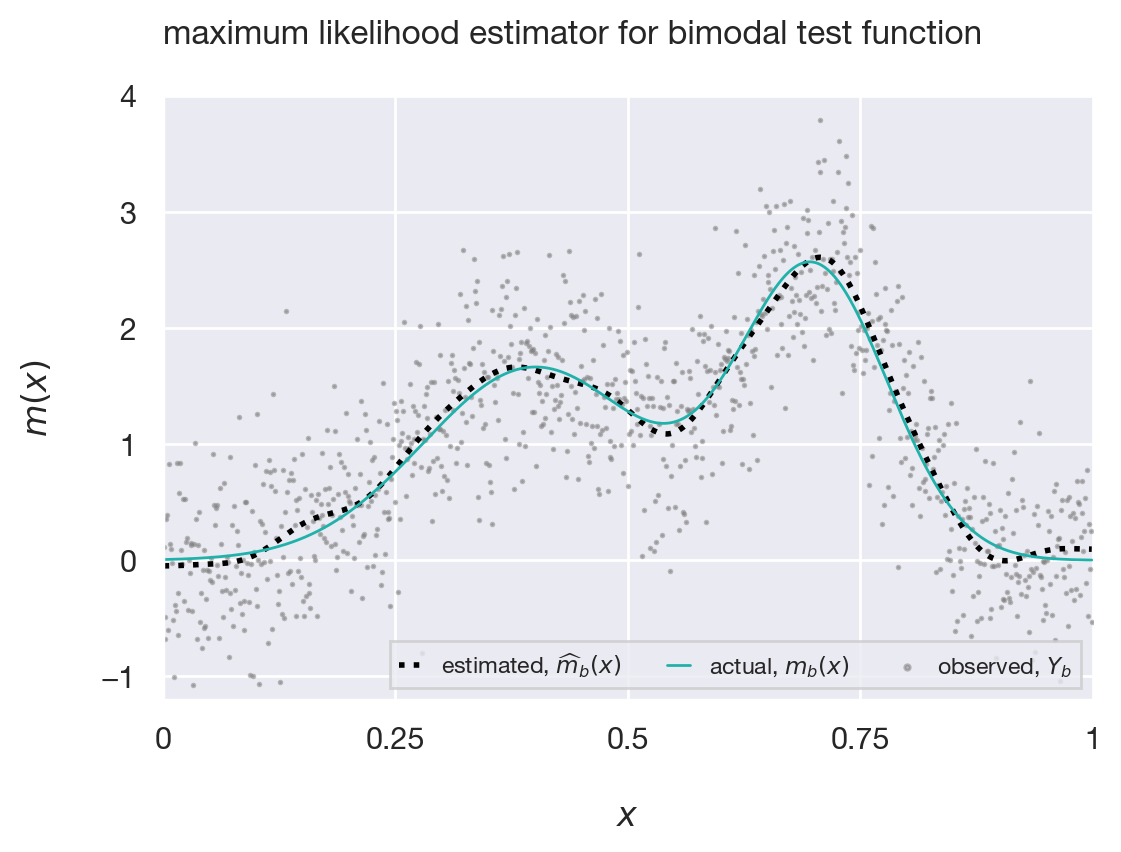

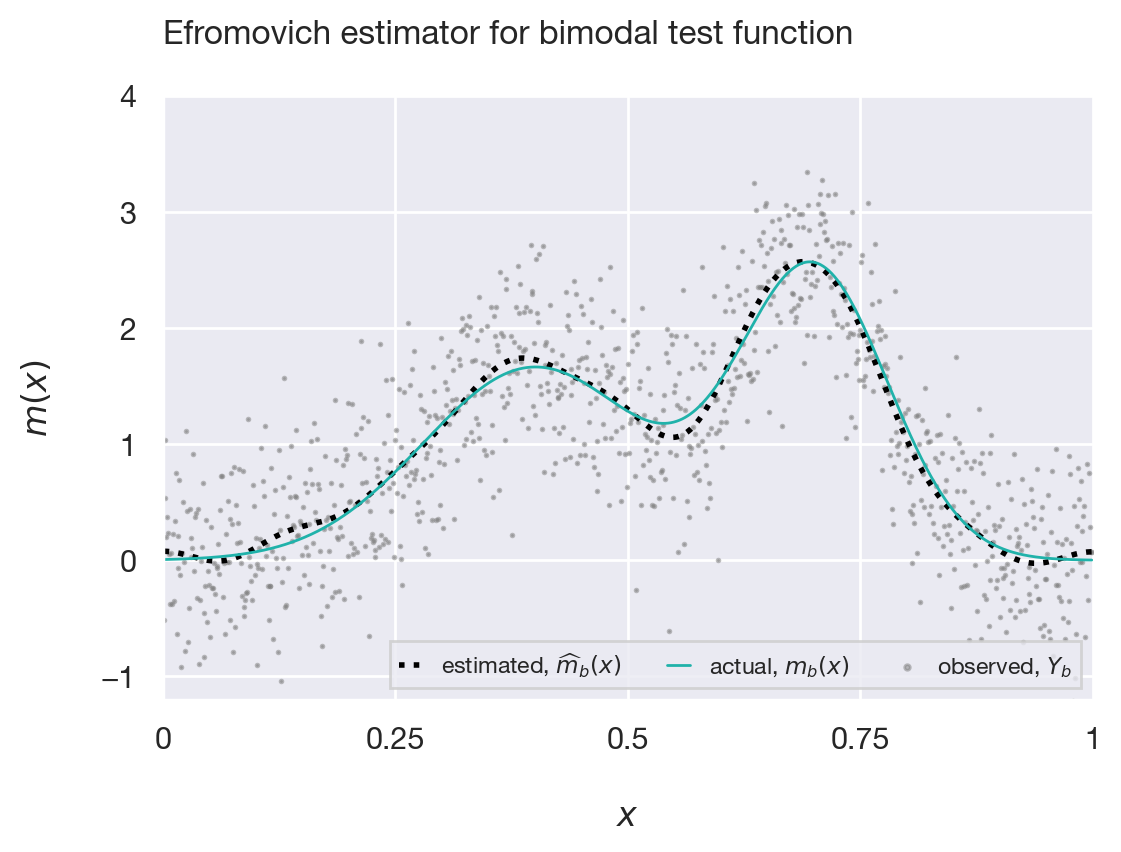

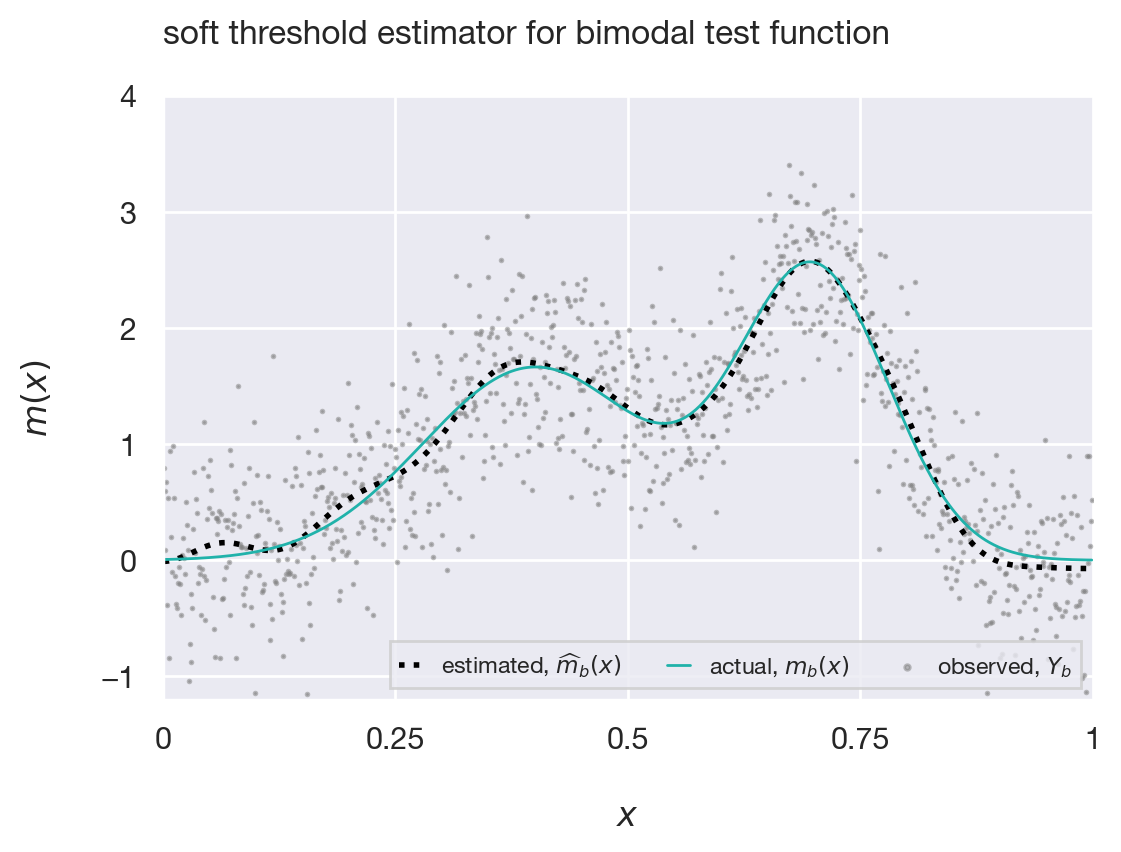

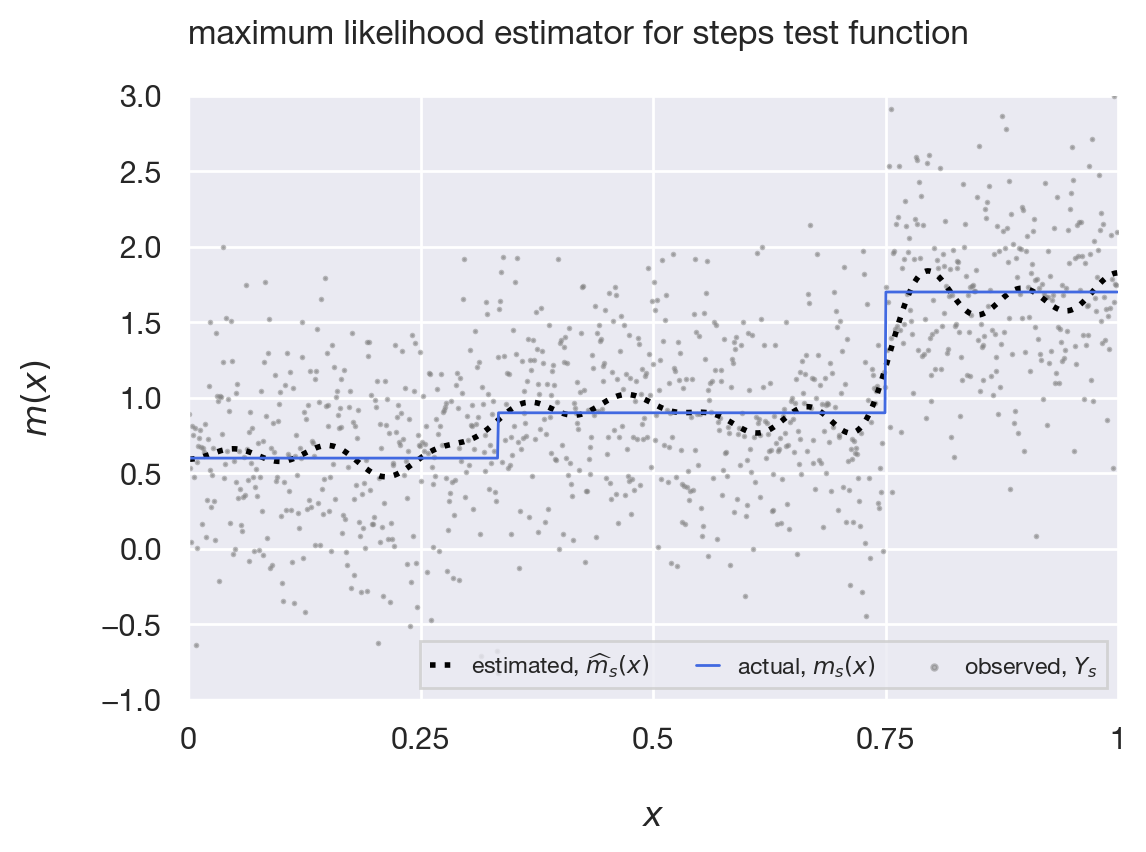

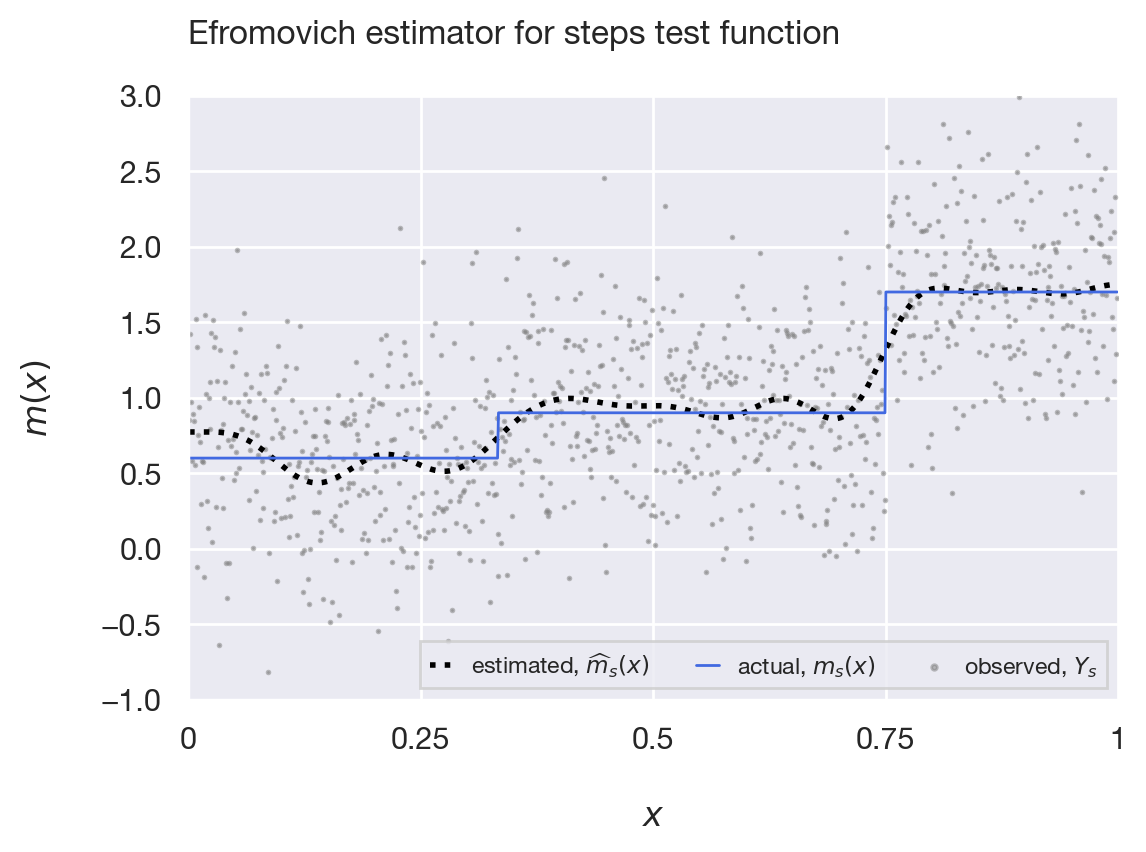

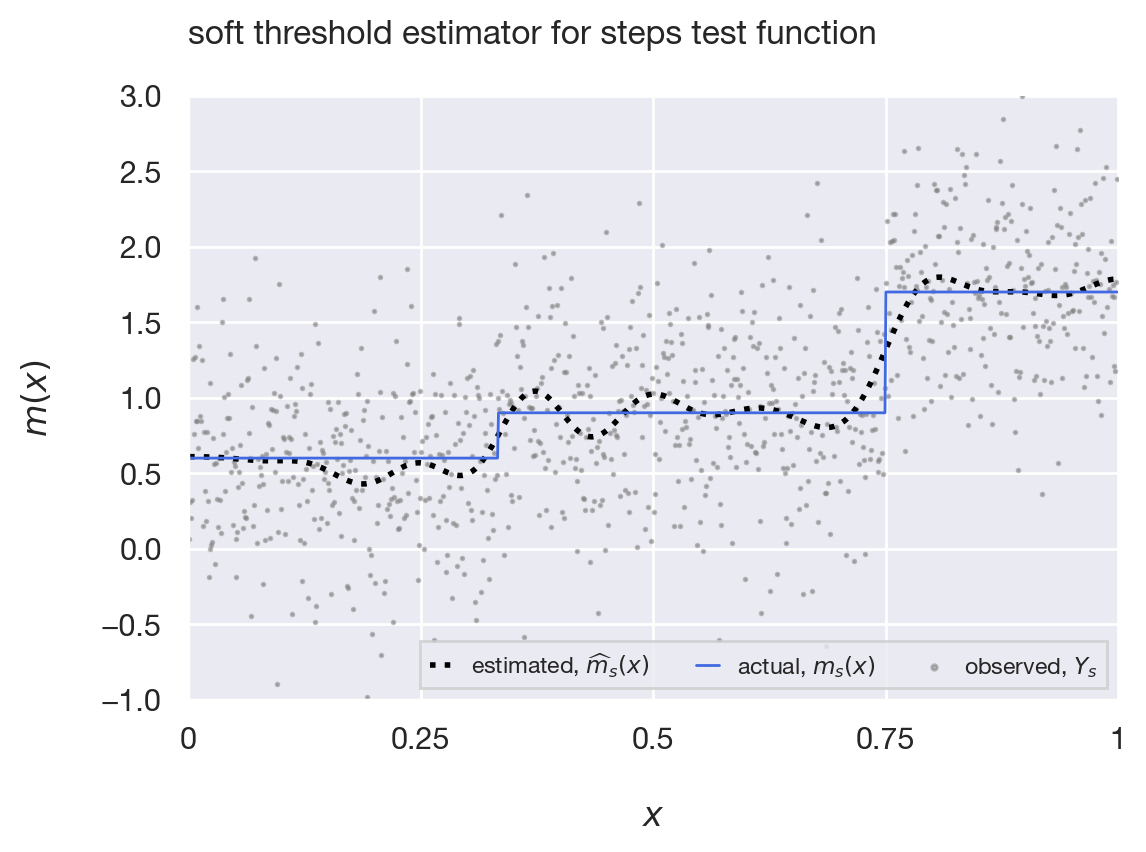

In [9]:
# get the median loss sample index for each (test_function, estimator)
ranked = sorted_loss.rank()
median_indices = ranked[ranked["loss"] == t//2].reset_index(level = -1)["sample_number"].loc[m̂.keys()]
for ((j, e), idx) in median_indices.items():
    plt.scatter(X, Y[j][idx],       label = "observed, $Y_" + j[0] + "$",               color = "grey",    s = 1, alpha = 0.5)
    plt.plot   (X, m̂[j, e][:, idx], label = "estimated, $\widehat{m}_" + j[0] + "(x)$", color = "black",   linewidth = 2, linestyle = "dotted")
    plt.plot   (X, m[j](X),         label = "actual, $m_" + j[0] +"(x)$",               color = colors[j], linewidth = 1)
    plt.legend(loc = "lower right", fontsize = "x-small", ncol = 3, markerscale = 2, handlelength = 1, fancybox = False)
    plt.title(f"{e} estimator for {j} test function\n", loc = "left")
    plt.xlabel("\n$x$")
    plt.ylabel("$m(x)$\n")
    plt.xlim(0, 1)
    plt.ylim(*ylims_data[j])
    plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
    plt.show()

### Comments/Conclusion
- For the bimodal test function, soft thresholding performs better than the maximum likelihood estimate in a square-error sense, but both are dominated by the Efromovich estimator.

- For the steps test function, there is not an appreciable difference when looking at each estimator's square loss. However, we can look at the estimator plots and note that the maximum likelihood estimator shows the characteristic overshoot of using a finite basis of trigonometric functions to approximate piecewise functions ("Gibb's phenomenon"). The smoothing properties of both the Efromovich and soft threshold estimators resolve this somewhat.


# 2. K Normal Means, Application

We start by downloading and formatting the data, and by creating the (non-orthonormal) design matrix. I made the decision to drop rows with NA values for `logYL`.

In [122]:
# download the data
hj_raw = requests.get("https://web.stanford.edu/~chadj/HallJones400.asc").text.split("\n")

# extract the relevant rows for Table 2 and read them into a dataframe 
table2_rows = io.StringIO("\n".join(
    takewhile(lambda _: _, 
    dropwhile(lambda _: not _.startswith("Code  Country"), hj_raw))
))
hj_table2 = pd.read_fwf(table2_rows, skiprows = [1])

# split some non-fixed-width columns and perform some data reorganization
for colname in [hj_table2.columns[_] for _ in [0, 2, -1]]:
    hj_table2[colname.split()] = hj_table2[colname].str.split(expand = True, n = 1)
    hj_table2.drop(columns = colname, inplace = True)
hj_table2["logYL"   ] = hj_table2["logYL"   ].astype(float)
hj_table2["Latitude"] = hj_table2["Latitude"].astype(float)
hj_table2.set_index("Country", inplace = True)
hj_table2.dropna(inplace = True)
hj_table2.sort_values(by = "Latitude", inplace = True)

(hj_table2)

,Sample?,logKL,alogKY,School,logHL,logA,logL,Mining,EcOrg,SocInf,YrsOpen,GADP,EngFrac,EurFrac,Code,Imputed?,logYL,log(FrankRom),Latitude
Country,,,,,,,,,,,,,,,,,,,
New zealand,1,11.26508,0.56121,12.04,1.21472,8.36672,14.21071,0.011,5,0.59300,0.200,0.986,0.90,0.900,NZL,0,10.14265,2.103,-36.892
Argentina,1,10.40884,0.40307,6.68,0.80668,8.39295,16.22535,0.023,5,0.33411,0.089,0.579,0.00,0.836,ARG,0,9.60270,1.723,-36.676
Uruguay,1,10.06039,0.33235,6.45,0.78345,8.27988,13.98932,0.001,3,0.33739,0.111,0.564,0.00,1.000,URY,0,9.39568,2.837,-34.822
Chile,1,10.01913,0.43944,6.45,0.78345,7.91736,15.34372,0.155,5,0.53428,0.422,0.646,0.00,0.931,CHL,0,9.14025,1.981,-33.554
Australia,1,11.38595,0.54087,10.24,1.09232,8.67103,15.87232,0.038,5,0.80978,0.689,0.931,0.95,0.950,AUS,0,10.30421,1.404,-32.219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Denmark,1,11.16358,0.52940,10.33,1.09844,8.47693,14.85564,0.006,4,0.88089,0.778,0.984,0.00,0.005,DNK,0,10.10478,3.430,55.718
Sweden,1,11.19516,0.47964,9.45,1.03860,8.71764,15.28438,0.003,4,0.88239,0.778,0.987,0.00,0.000,SWE,0,10.23588,2.903,59.278
Norway,1,11.45985,0.62991,10.38,1.10184,8.46829,14.56454,0.079,4,0.87272,0.778,0.968,0.00,0.000,NOR,0,10.20004,3.159,59.977


With the data loaded, we can construct and inspect the design matrix as specified. Note that Hall and Jones's regression is against absolute latitude divided by 90, but we regress against latitude for simplicity.

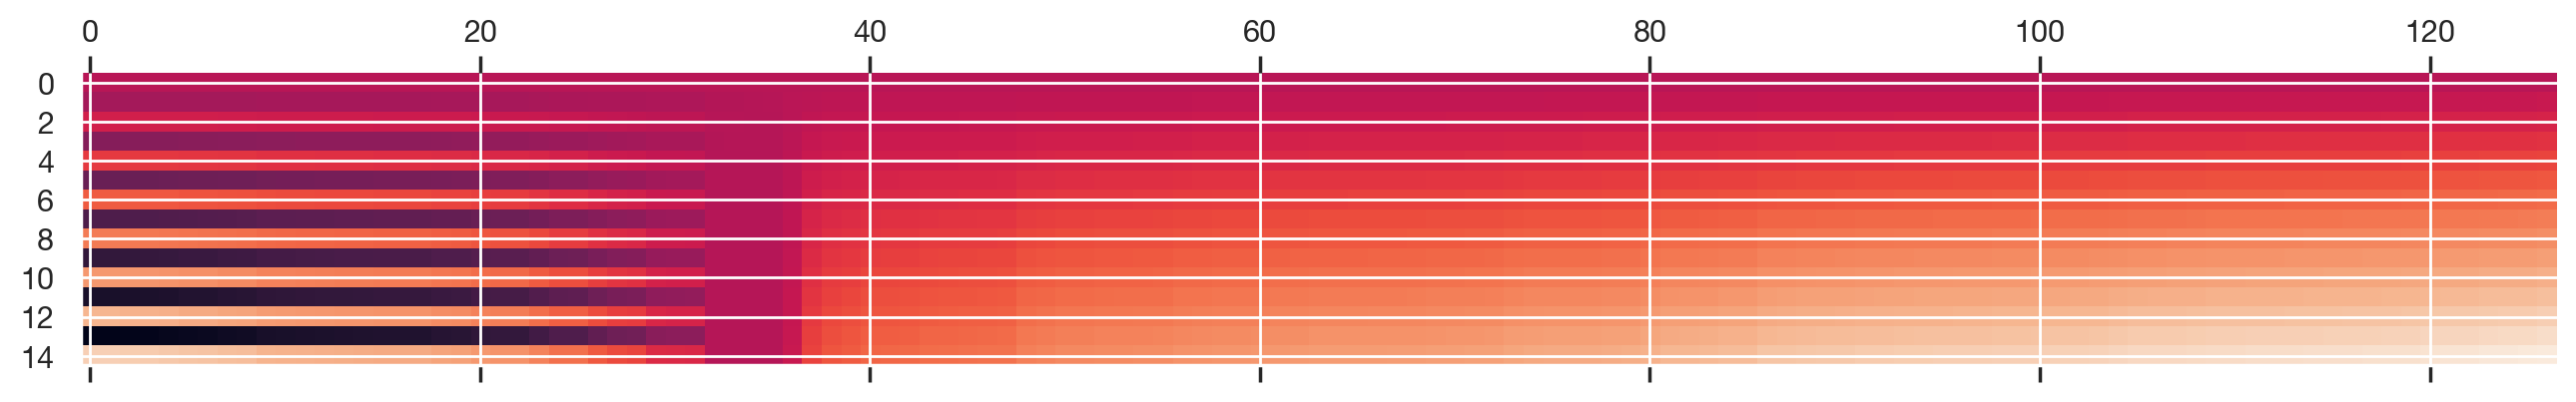

In [136]:
# size of basis for regression
K = 15

# extract the target variable for the prediction task, and create the design matrix
Y = logYL     = hj_table2["logYL"   ].to_numpy()  
ϕ = latitude  = hj_table2["Latitude"].to_numpy()
design_matrix = (ϕ ** np.arange(0, K)[:, None]).T

# take a look at the design matrix to make sure it looks right
plt.matshow(np.arcsinh(design_matrix).T)

Note the high regularity in the image representation of the design matrix, indicating that it is not full-rank. We can apply the Gram-Schmidt procedure to get an orthonormal version of our design matrix:

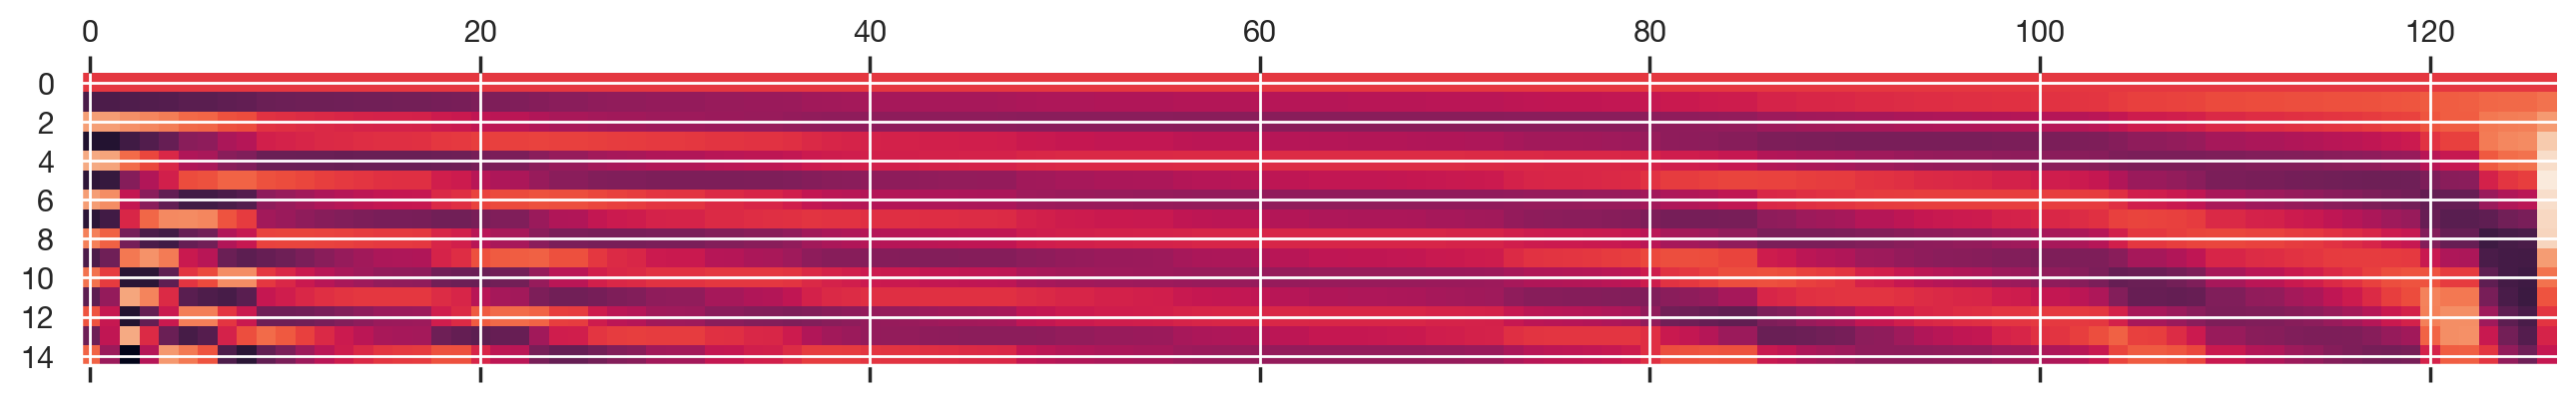

In [125]:
def gram_schmidt(X):
    # start with empty set so first vector is automatically normalized
    U = [] 
    for x in X.T: # iterate over columns 
        # project each vector onto existing set 
        u = x - sum([x.dot(u)/u.dot(u) * u for u in U]) 
        # add normalized non-zero vector to set 
        if np.any(u): U.append(u/np.linalg.norm(u)) 
    return np.array(U).T

W = orthonormal_basis = gram_schmidt(design_matrix)

plt.matshow(np.arcsinh(orthonormal_basis).T)


This reduces the linear dependence between the columns of the design matrix, making it appropriate for regression. Using the four specified methods (MLE, soft-thresholding, ordered-subset selection, and Efromovich), we can now compute the conditional mean of log(GDP/worker) given latitude, 
$$\mathbb{E}\left[ \log(y_i)\,|\, \Phi = \phi_i \right] $$

where  $y \equiv Y/L$ (cf. Hall and Jones, 1998, Equation (3)), and $\Phi$ represents latitude.

In [151]:
Ŷ = {}
N = len(Y)

# maximimum likelihood estimator
Z     = (Y @ W).T
Ŷ[ML] = W.dot(Z)

# Efromovich
σ     = np.var(Y - Ŷ[ML]) # use empirical variance of MLE estimate
ĉ     = np.clip(1 - (σ**2/N) * Z**-2, 0, None)
Ŷ[Ef] = W.dot(ĉ * Z)

# soft thresholding
l     = np.linspace(-1, 1, 5000)[:, None, None]
R̂_ST  = -2*σ**2/N * (np.abs(Z) > l).sum(axis = 1) + np.minimum(Z**2, l**2).sum(axis = 1) # again, ignore constant term for optimizing 
λ     = l[np.argmin(R̂_ST, axis = 0)].flatten()
Ŷ[ST] = W.dot(np.where(np.abs(Z) > λ, Z + np.sign(Z) * λ, 0))

# ordered subset selection
M     = np.argmin(np.triu(np.ones(K)).dot(Z**2 - σ**2) + σ**2 * np.arange(1, K + 1))
Ŷ[OS] = W.dot(np.where(k < M, Z, 0))

# show the MSE performance of each estimator
pd.DataFrame(
    [(method, np.mean((Y - estimate)**2)) for (method, estimate) in Ŷ.items()], 
columns = ["method", "average_loss"])\
.set_index("method")\
.sort_values(by = "average_loss")

,average_loss
method,
maximum likelihood,0.599419
soft threshold,0.599420
Efromovich,0.599467
ordered subset,0.676126


Finally, we can also visualize the results.

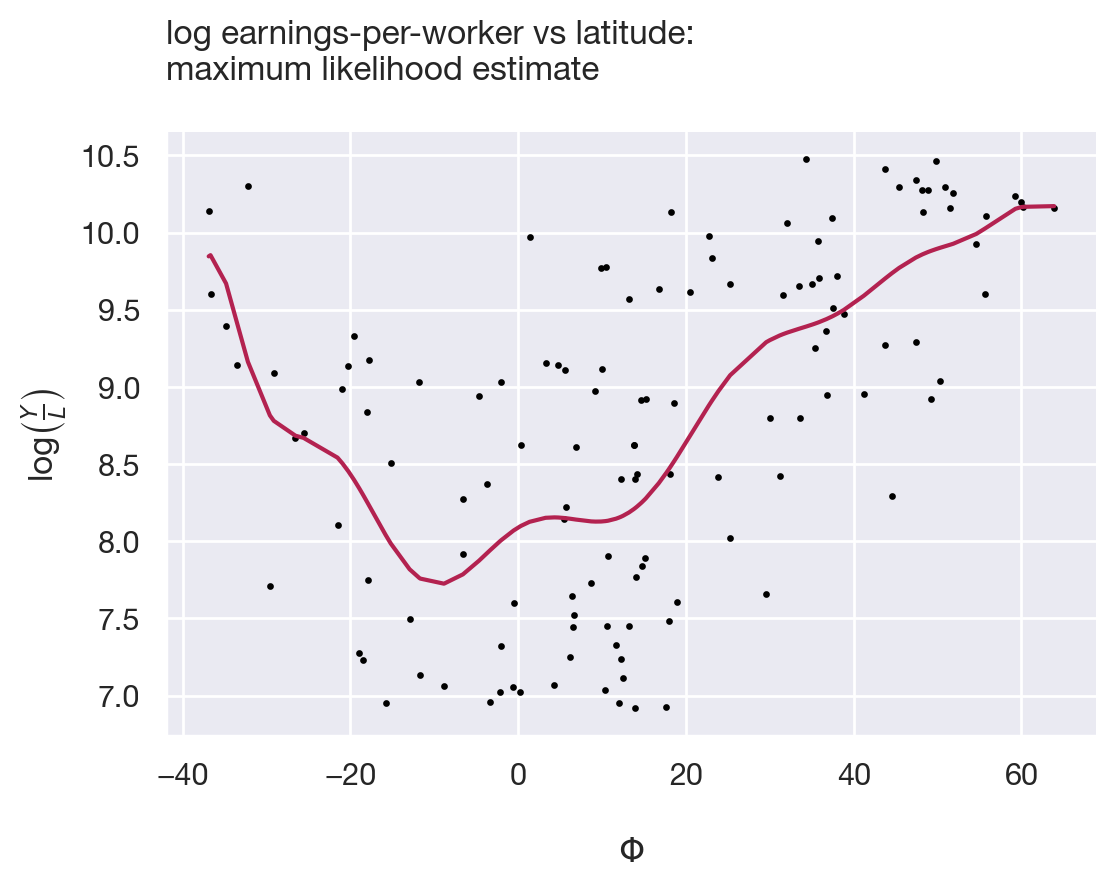

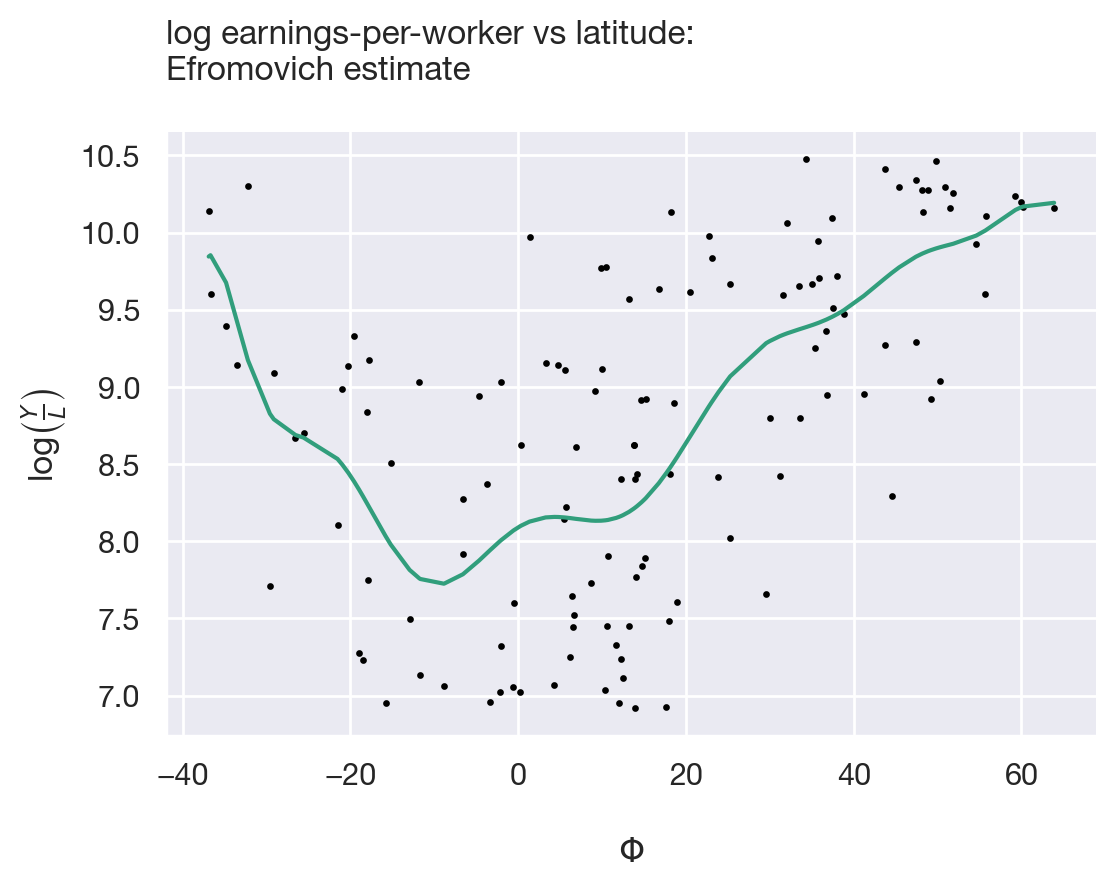

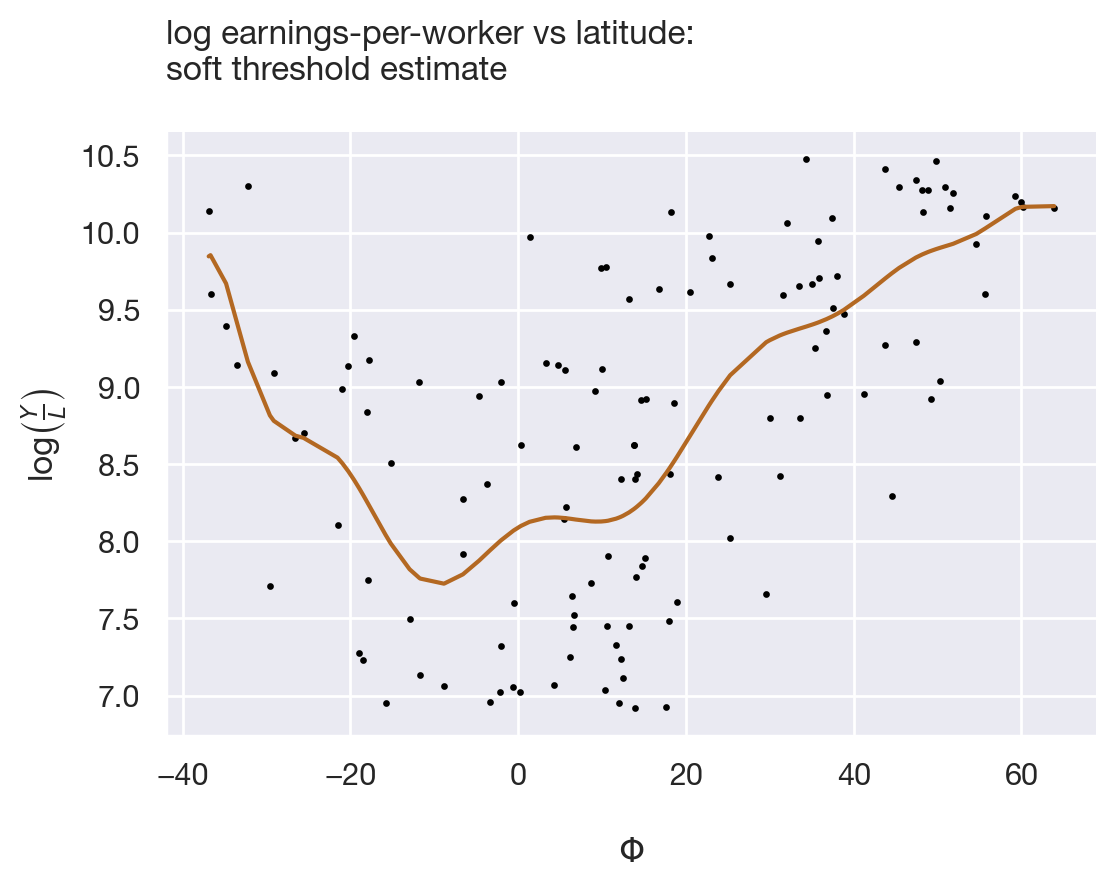

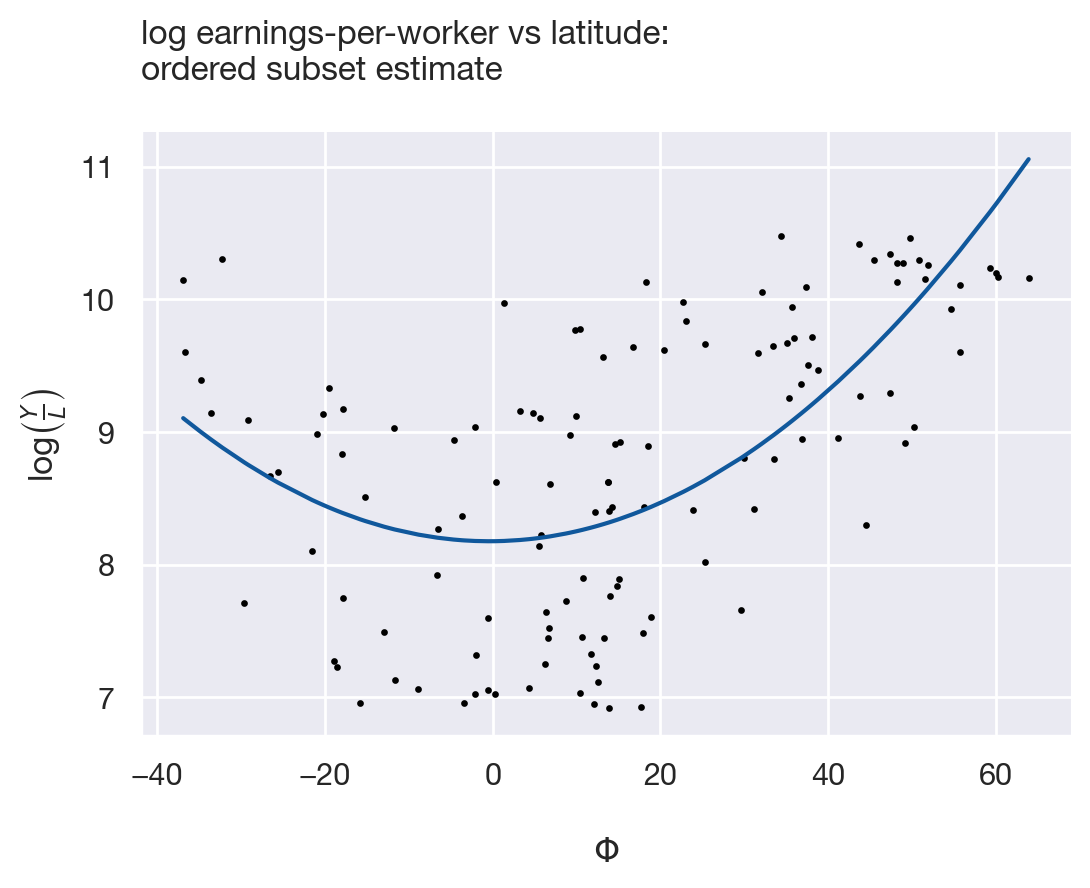

In [144]:
palette = ["#B32250", "#319E7C", "#B36822", "#10589C"]
for ((method, estimate), color) in zip(Ŷ.items(), palette):
    plt.scatter(ϕ, Y,        color = "black", label = "observed", s = 2)
    plt.plot   (ϕ, estimate, color = color,   label = "estimated")
    plt.title(
        "log earnings-per-worker vs latitude:\n" + 
        f"{method} estimate\n", 
        loc = "left"
    )
    plt.xlabel("\n$\Phi$")
    plt.ylabel("log$\left( \\frac{Y}{L} \\right)$")
    plt.show()